In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
import matplotlib.animation as animation
from IPython.display import HTML, Image

from tensorflow.keras.models import load_model
import tensorflow as tf


import pydot
from IPython.display import Image, display
import imageio

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [3]:
from Env.Simulator_New import Simulator
param_model = load_model("param_model.h5")
dqn_model = load_model("dqn_model.h5")
from tester import Tester
reward_data = np.loadtxt("rewards.csv", delimiter = ",")

TODO: constrain actions within action select in agent
Add action: sell stream


In [4]:
tester = Tester(param_model, dqn_model, Simulator())
env = tester.test()
env.column_streams

Vessel internal diameter is too high
stream [9.10000000e+00 6.80000000e+00 9.10000000e+00 6.79320009e+00
 6.79991245e-03 0.00000000e+00] is seperated with an LK of 3 with a split of [0.99900001]
stream [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.79991245e-03
 6.79320009e+00 6.80000000e+00] is seperated with an LK of 2 with a split of [0.99900001]
stream [9.10000000e+00 6.80000000e+00 9.09090012e+00 6.79311263e-03
 0.00000000e+00 0.00000000e+00] is seperated with an LK of 4 with a split of [0.99900001]
Vessel height is too large
stream [9.10000000e+00 6.79320009e+00 9.09078308e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00] is seperated with an LK of 1 with a split of [0.99900001]
stream [0.00909988 6.78640697 0.00909078 0.         0.         0.        ] is seperated with an LK of 0 with a split of [0.99900001]


[(0, 1, 2), (1, 3, 4), (2, 5, 6), (3, 7, 8), (7, 9, 10)]

In [23]:
env.column_dimensions

[[array([170.54295378]), 16.708038848543957],
 [array([34.2321127]), 1.5412786970265755],
 [array([27.22224628]), 2.9109326292618616],
 [array([152.97206994]), 18.02810444271286],
 [array([28.60326641]), 2.3395303197796222]]

In [24]:
def find_column(stream):
    for i in range(len(env.column_streams)):
        if stream in env.column_streams[i]:
            if env.column_streams[i][1] == stream:
                loc = "ne"
            elif env.column_streams[i][2] == stream:
                loc = "se"
            else: print("error")
            return i, loc

In [27]:
G = pydot.Dot(graph_type="digraph", rankdir = "LR")
outlet_nodes = []
nodes = []
edges = []
image_list = []

In [28]:
for i in range(len(env.sep_order)):
    LK = env.sep_order[i]
    split = env.split_order[i].round(3)[0]
    nodes.append(pydot.Node(f'Column {i+1} \nLK is {LK} \nsplit is {split}', shape ="square"))
    G.add_node(nodes[i])
    if i > 0:
        stream_in = env.column_streams[i][0]
        column_link, loc = find_column(stream_in)
        edges.append(pydot.Edge(nodes[column_link], nodes[i], headport = "w", tailport = loc ))
        G.add_edge(edges[i-1])
        
    tops, bottoms = env.column_streams[i][1:]     
    if tops in env.outlet_streams:
        stream = env.stream_table[tops]
        flowrate = int(stream.sum())
        purity = int(100*stream.max()/stream.sum())
        compound = stream.argmax()
        compound = env.compound_names[compound]
        outlet_nodes.append(pydot.Node(f"{flowrate} kmol/s \n{purity}% {compound} ", shape = "box", color = "white"))
        G.add_node(outlet_nodes[-1])
        G.add_edge(pydot.Edge(nodes[i], outlet_nodes[-1], headport = "w", tailport = "ne" ))
        
    if bottoms in env.outlet_streams:
        stream = env.stream_table[bottoms]
        flowrate = int(stream.sum())
        purity = int(100*stream.max()/stream.sum())
        compound = stream.argmax()
        compound = env.compound_names[compound]
        outlet_nodes.append(pydot.Node(f"{flowrate} kmol/s \n{purity}% {compound}", shape = "box", color = "white"))
        G.add_node(outlet_nodes[-1])
        G.add_edge(pydot.Edge(nodes[i], outlet_nodes[-1], headport = "w", tailport = "se" ))
        
    BFD = imageio.imread(G.create_png())
    image_list.append(BFD)

In [29]:
image_list[0].shape, image_list[-1].shape

((127, 127, 4), (440, 827, 4))

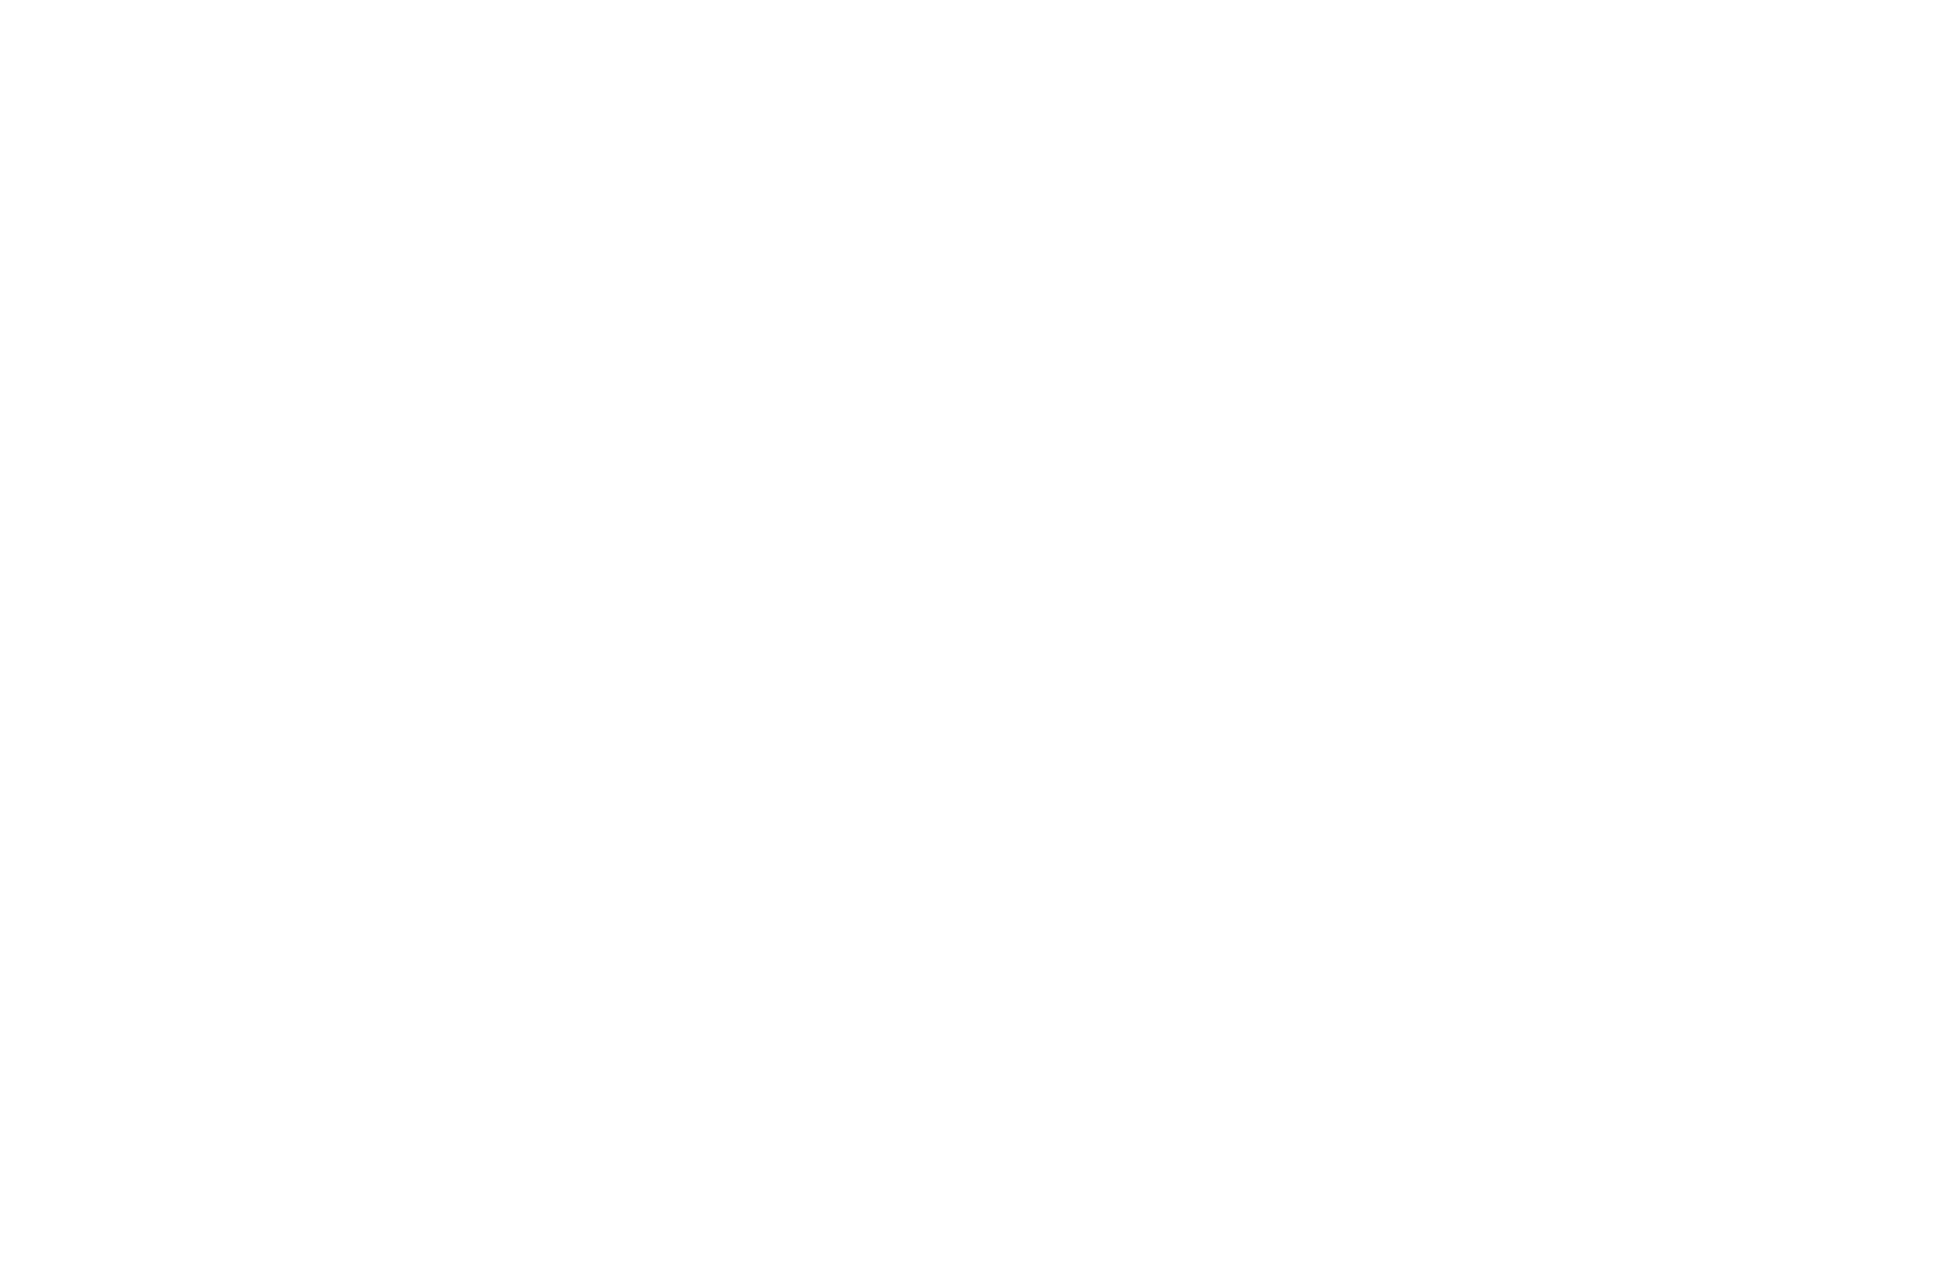

In [42]:
final_image_width = image_list[-1].shape[1]
final_image_height = image_list[-1].shape[0]
max_width = 20
max_height = 20*final_image_height/final_image_width 
fig, ax = plt.subplots()
ax.set_xlim(0,max_width)
ax.set_ylim(0, max_height)
ax.axis('off')
matplotlib.rcParams['figure.dpi']= 800

In [43]:
images = []
for i in range(len(image_list)):
    image_width = image_list[i].shape[1]
    image_height = image_list[i].shape[0]
    image = ax.imshow(image_list[i], extent = [0, max_width*image_width/final_image_width, 
                                               0, max_height*image_height/final_image_height])
    images.append([image])

In [44]:
animation_BFD = animation.ArtistAnimation(fig, images, interval=1000, blit=True,
                                repeat_delay=1000)
animation_BFD.save('BFD_DC.gif', writer='imagemagick', fps=1)

In [45]:
Image(url='BFD_DC.gif')

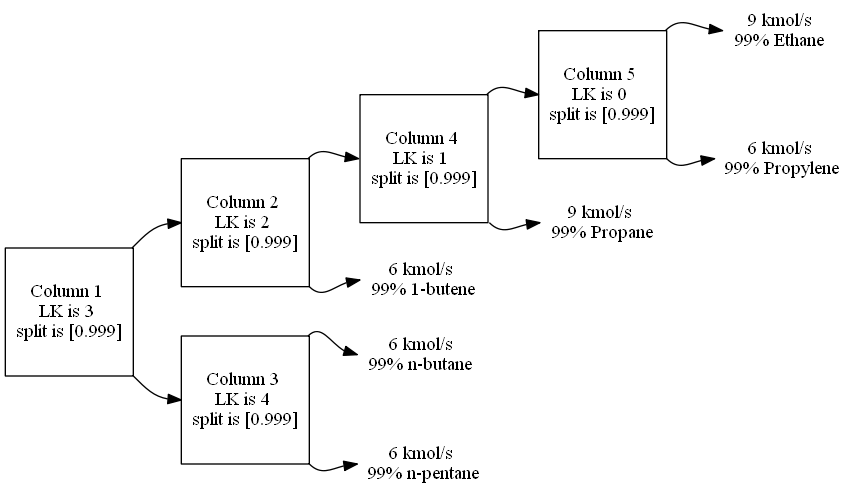

In [17]:
im = Image(G.create_png())
im

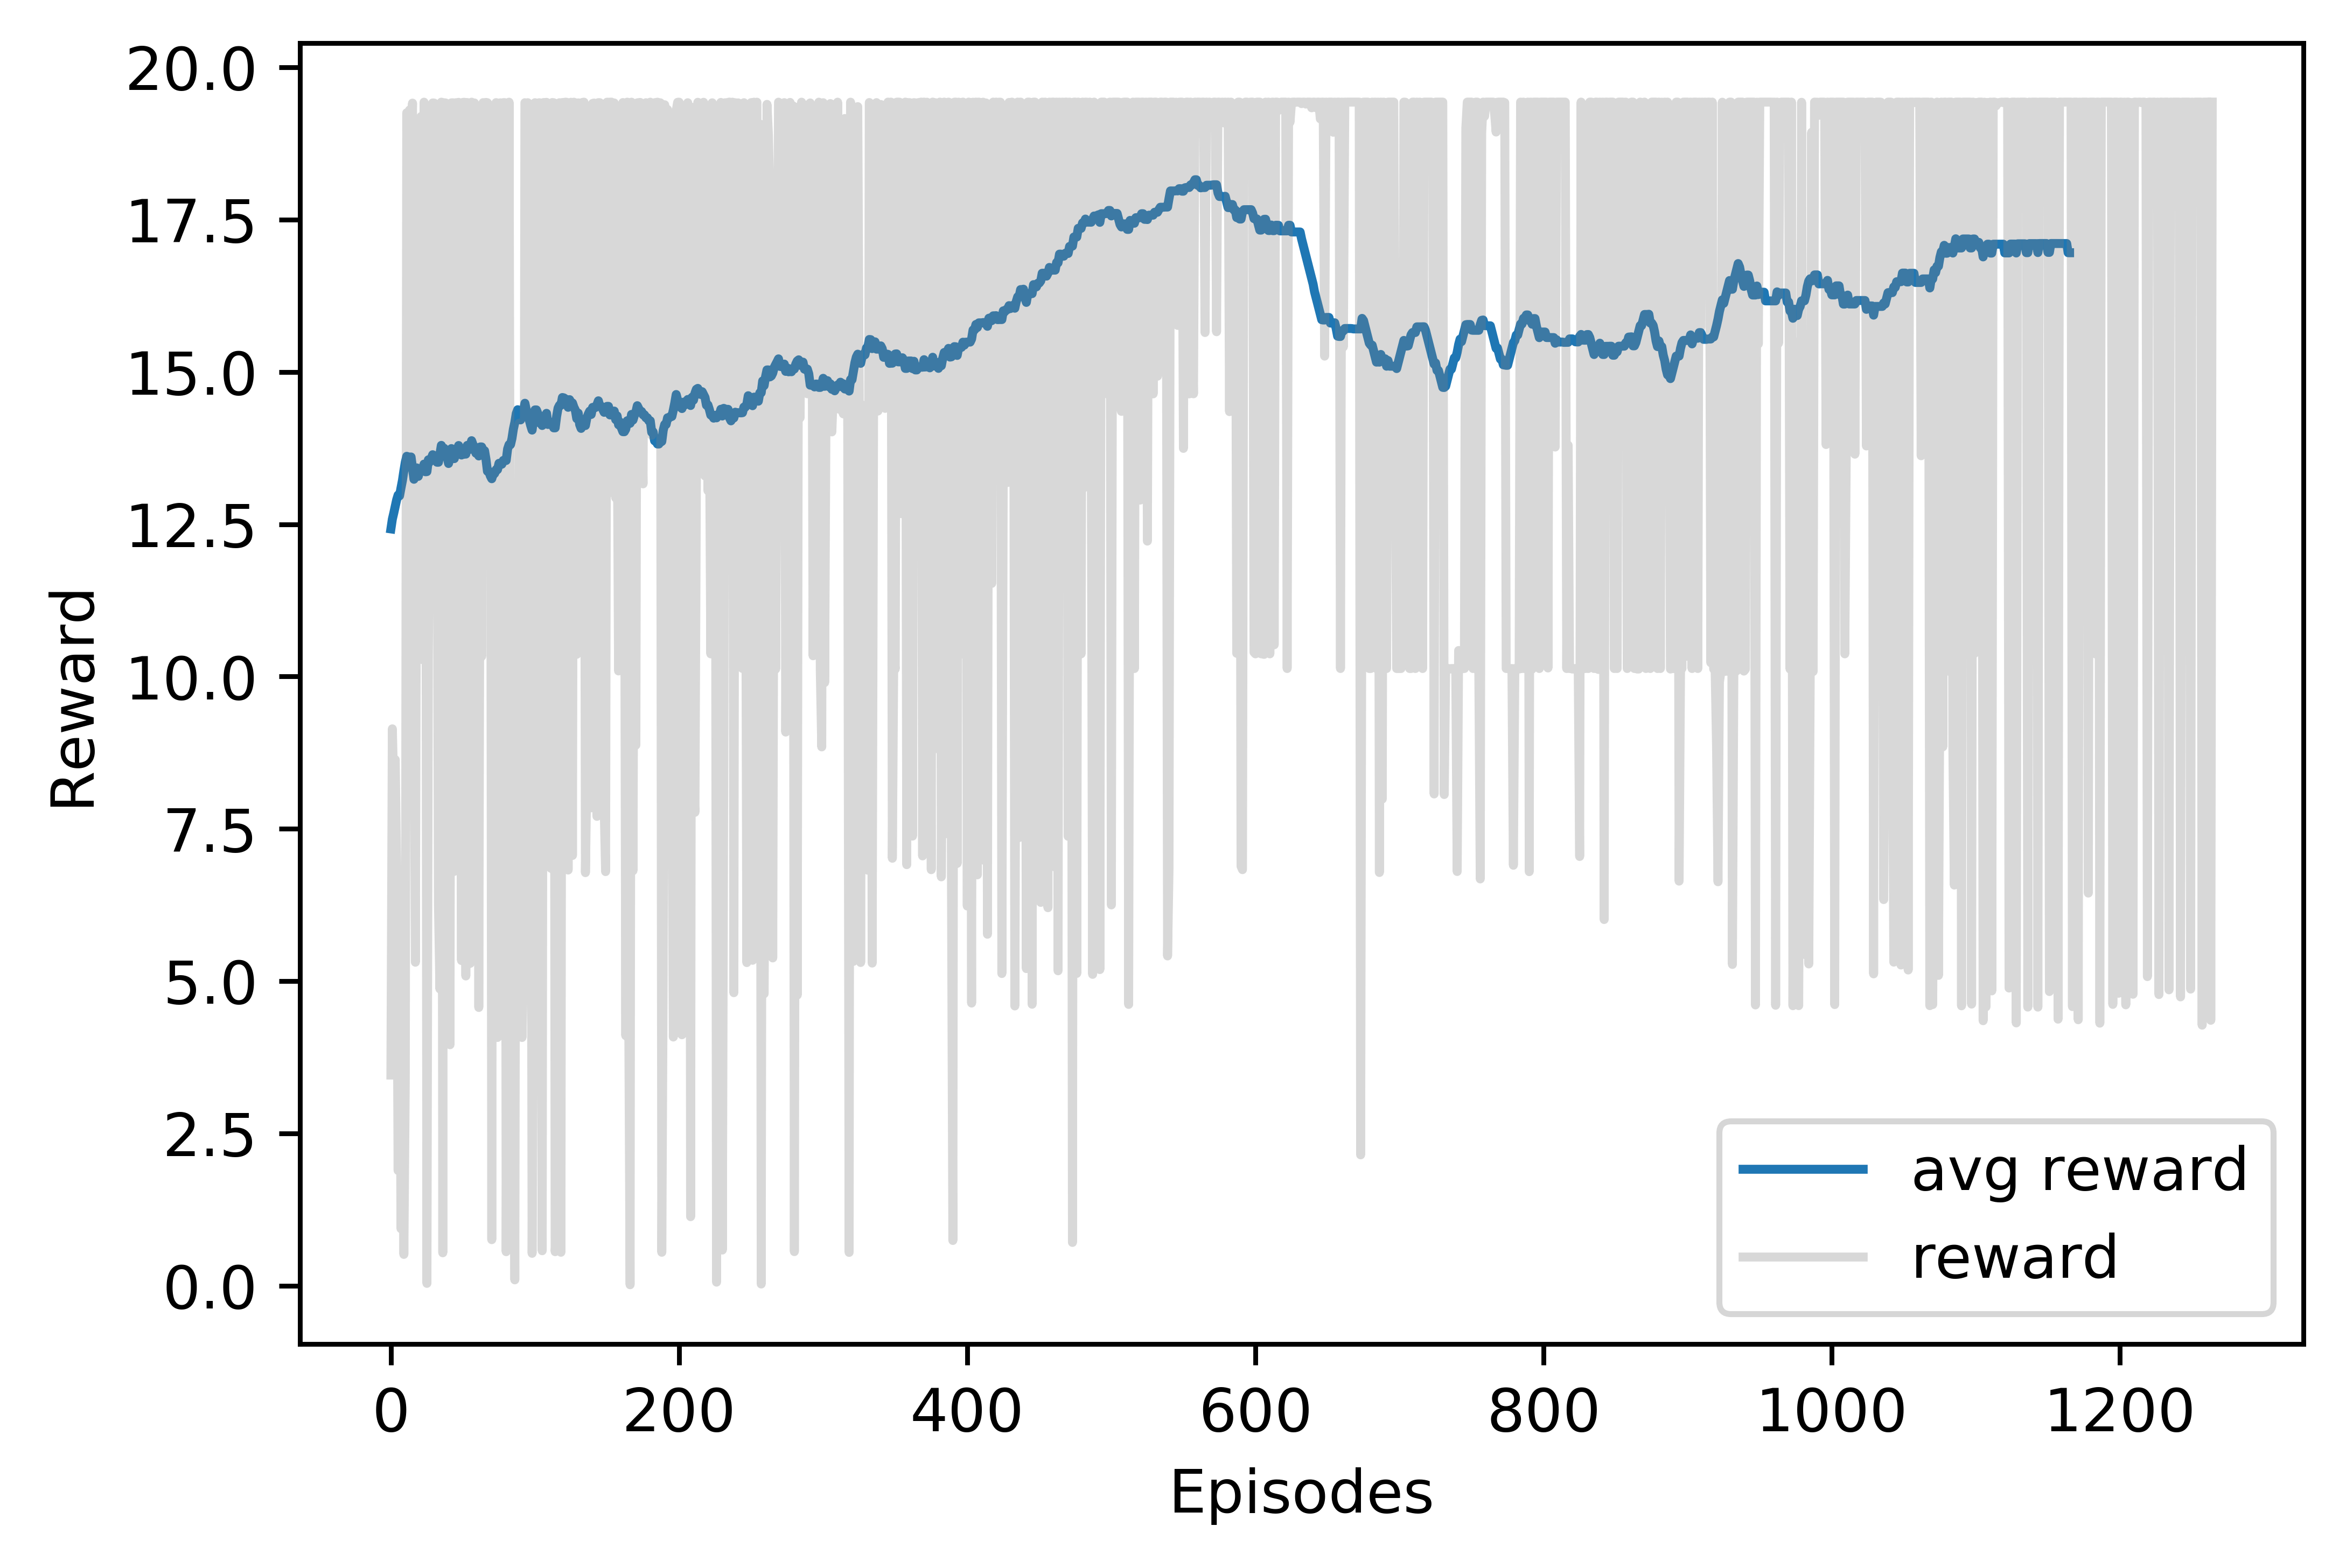

In [46]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

smoothed_rews = running_mean(reward_data, 100)
plt.plot(np.arange(np.shape(smoothed_rews)[0])[-len(smoothed_rews):], smoothed_rews)
plt.plot(np.arange(np.shape(reward_data)[0]),reward_data,color='grey', alpha=0.3)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend(["avg reward", "reward"], loc=4)
plt.savefig('Learning.png', bbox_inches='tight')

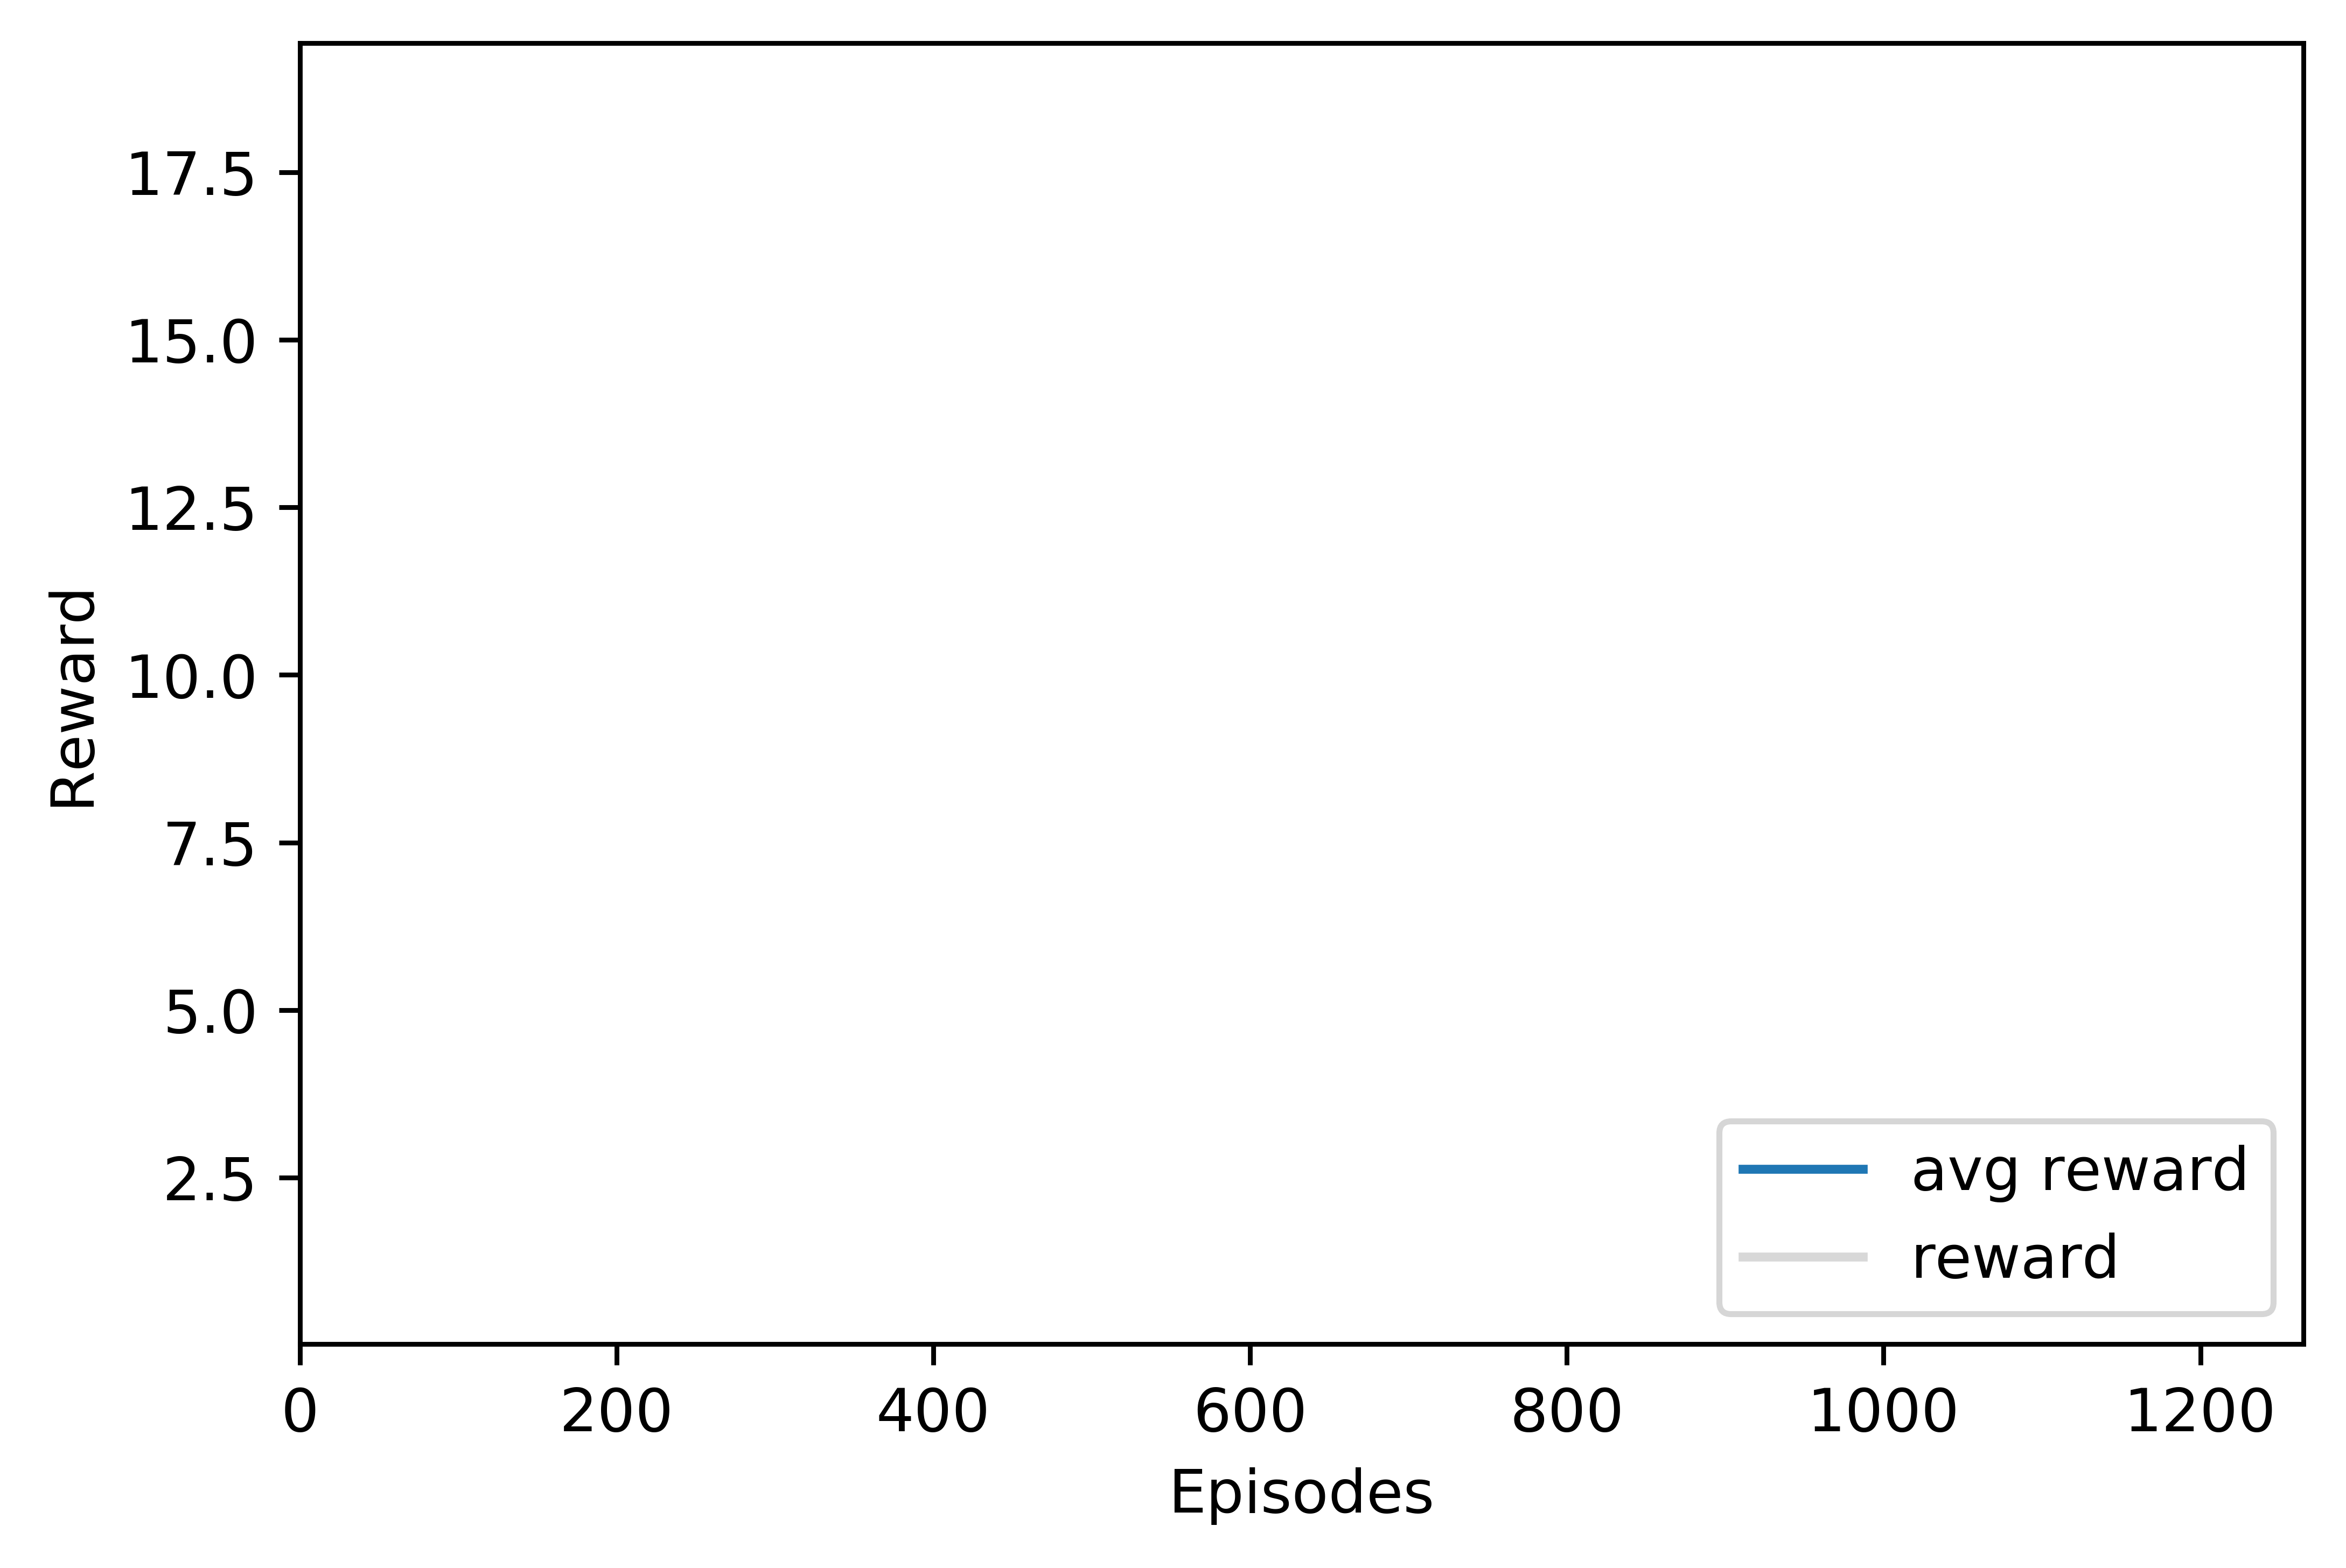

In [49]:
fig, ax = plt.subplots()
ax.set_xlabel("Episodes")
ax.set_ylabel("Reward")
ax.set_xlim(0,len(reward_data))
ax.set_ylim(reward_data.min(), reward_data.max())
interval = 30

lines = []
line1, = ax.plot([], [])
lines.append(line1)
line2, = ax.plot([], [],color='grey', alpha=0.3)
lines.append(line2)
ax.legend(["avg reward", "reward"], loc=4 )

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def anim(i):
    smoothed_rews_ = smoothed_rews[0:i*interval]
    reward_data_ = reward_data[0:i*interval]
    lines[0].set_data(np.arange(np.shape(smoothed_rews_)[0])[-len(smoothed_rews_):], smoothed_rews_)
    lines[1].set_data(np.arange(np.shape(reward_data_)[0]),reward_data_)
    return lines

In [ ]:
anim_Learn = animation.FuncAnimation(fig, anim, frames = round(len(smoothed_rews)/interval), init_func=init, interval = 200, blit = True)

In [ ]:
rc('animation', html='html5')
anim_Learn

In [ ]:
anim_Learn.save('Learning.gif', writer='imagemagick', fps = 10)
Image(url='c.gif')